In [1]:
ENV["PYTHONPATH"] = "/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
D = 2;
using HDF5, PyPlot
using DelimitedFiles, PyPlot, LinearAlgebra, JLD2, PyCall, StaticArrays, Statistics
using Crystalline, Brillouin, MPBUtils, SymmetryBases
using Crystalline: TEST_αβγs, TEST_αβγ, dot, norm
using Crystalline: normscale, matching_littlegroups
using Crystalline: AbstractFourierLattice
topology_paper_dir = "../../TopologyPaper/"
include(topology_paper_dir * "get-freqs-symeigs.jl")
include(topology_paper_dir * "symeigs-from-io.jl");
include("../../Topology_ML/Phc_ML/fft.jl")
include("../get_uc_coefs.jl");
np = pyimport("numpy");

In [5]:
file = h5open("sg2-data.h5", "r");

### We compute the absolute gaps for each photonic crystal in the dataset in order to find the best candidate

In [6]:
gaps = Float64[]
for gidx in 1:4
    for id in range(1, 10000)
        min_band_2 = minimum(file["sg2/$id/frequencies-gidx=$gidx-mode=tm"][][:, 2], dims=1)
        max_band_1 = maximum(file["sg2/$id/frequencies-gidx=$gidx-mode=tm"][][:, 1], dims=1)
        push!(gaps, first(min_band_2-max_band_1))
    end
end

In [7]:
println("Maximum absolute gap across dataset: ", maximum(gaps))

Maximum absolute gap across dataset: -0.0009409999999999974


### From the above, we see that none of the photonic crystals have a complete gap. So we instead find the one with the best k-wise gap 

In [9]:
gaps = Float64[]
for gidx in 1:4
    for id in range(1, 10000)
        gap_per_k = file["sg2/$id/frequencies-gidx=$gidx-mode=tm"][:, 2] - file["sg2/$id/frequencies-gidx=$gidx-mode=tm"][:, 1]
        push!(gaps, minimum(gap_per_k))
    end
end

In [10]:
println("Candidate index with best k-wise gap: ", argmax(gaps))

Candidate index with best k-wise gap: 9375


In [11]:
println("Fourier components corresponding to best k-wise gap candidate: ", file["sg2/$(argmax(gaps))/epsilon_Gs-gidx=1"][])

Fourier components corresponding to best k-wise gap candidate: [20.0, -0.9454920999564786, -0.9887601606404011, 0.9945229851172452, 0.3036058155447068, -0.0169716914685194, -0.5902919016746162, 0.27719477424933725, -0.8033843012998687, -0.7033731514525507]


In [12]:
println("Symmetry labels for the first 10 bands for the best k-wise gap candidate:", file["sg2/$(argmax(gaps))/symmetry-gidx=1-mode=tm"][])

Symmetry labels for the first 10 bands for the best k-wise gap candidate:[10, 13, 3, 4, 8, 7, 10, 5, 14, 9]


In [13]:
close(file)

# Check dielectric functions

In [14]:
file_dispersion = h5open("./dispersion/output/dim2-sg2-9375-res64-tm-epsilon.h5", "r");

In [15]:
epsilon_dispersion = file_dispersion["data"][];
close(file_dispersion)

In [16]:
file_original = h5open("./output/sg2/g1/tm/dim2-sg2-9375-res64-tm-epsilon.h5", "r");

In [17]:
epsilon_original = file_original["data"][];
close(file_original)

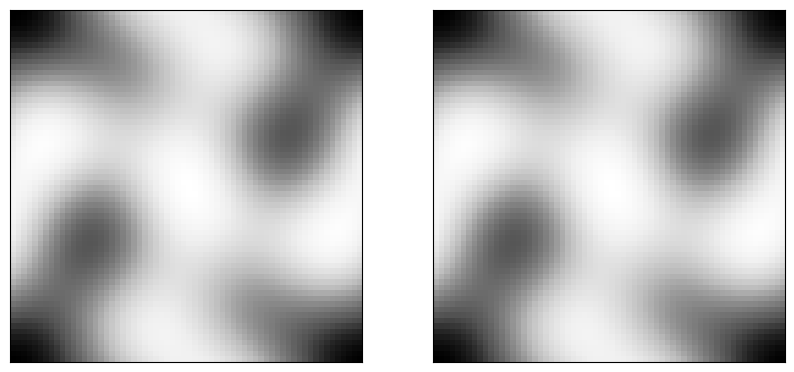

In [25]:
figure(figsize=(10, 5))
subplot(1, 2, 1)
imshow(epsilon_dispersion, cmap="Greys")
xticks([])
yticks([]);
subplot(1, 2, 2)
imshow(epsilon_original, cmap="Greys")
xticks([])
yticks([]);

In [19]:
io = open("./dispersion/logs/dim2-sg2-9375-res64-tm.log")
logstr = read(io, String)
close(io)

In [20]:
dispersion_str = logs_to_dispersion(logstr, "tm");

In [21]:
dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
kpts = readdlm(IOBuffer(dispersion_str), ',')[:, 2:4];

In [22]:
A_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0.5, 0] .- collect(row)) for row in eachrow(kpts)])
Gamma_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0, 0] .- collect(row)) for row in eachrow(kpts)])
B_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0, 0] .- collect(row)) for row in eachrow(kpts)]);
Y_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0.5, 0] .- collect(row)) for row in eachrow(kpts)]);

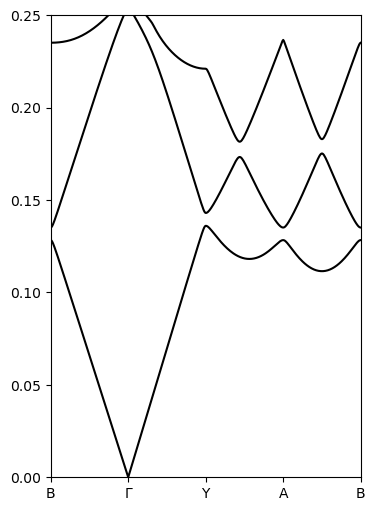

In [26]:
figure(figsize=(4, 6))
plot(1:405, dispersion[:, 1:3], color="black");
ylim(0, 0.25)
xlim(1, 405);
xticks([Gamma_point_idxs..., A_point_idxs..., B_point_idxs..., Y_point_idxs...], [repeat(["Γ"], length(Gamma_point_idxs))...,
        repeat(["A"], length(A_point_idxs))..., repeat(["B"], length(B_point_idxs))..., repeat(["Y"], length(Y_point_idxs))...])
;
#savefig("./figures/figure1-dispersion.pdf")